# Another machine learns to predict the stability of circumbinary planets

Builds on Lan and Kipling's 2017 article on binary star planets.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
#Blake: replace this with your import block when you run cuz we have slightly
#different setups
import sys
sys.path.append('/home/nbuser/courses/fastai/')

from fastai.structured import *
from fastai.column_data import *
from fastai import *
from sklearn.model_selection import *
from torch.nn.modules.loss import BCELoss
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn import metrics

np.set_printoptions(threshold=50, edgeitems=20)

sys.path.append('/home/nbuser/projects/astronomy/')
PATH='data/'
dirname = 'astronomy_data.txt'
data_path = f'{PATH}{dirname}'

In [ ]:
#additional way of doing log_loss for n=2 is binary_loss
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(np.sum(targets*np.log(predictions+1e-9)))/N
    return ce

In [ ]:
torch.cuda.is_available()

In [ ]:
torch.backends.cudnn.enabled

# Pulling in the data and the creating the training, validation, and test sets

In [ ]:
all_data = pd.read_csv('../'+data_path, sep=" ", header=None, low_memory=False)
all_data.columns = ['eccentricity', 'mass_ratio', 
                    'semi-major','frac_survived']

In [ ]:
display(all_data.head())

In [ ]:
all_data.describe()

In [ ]:
#alright let's turn it into floating point values
for v in all_data.columns: all_data[v] = all_data[v].astype('float32')

In [ ]:
all_data.dtypes

Lam and Kipping (2018) mention that they do different validation sets: "However, the outer edges of this region are deep
into stable and unstable territories, where both approaches
have a relatively easy job of picking out the correct answers.
To more rigorously evaluate the models, we filter our validation
set down to a sub-sample closely surrounding the
Holman & Wiegert (1999) boundary. We vary the envelope
sequentially in small steps, starting from a very tight envelope
and gradually expanding out to the far regions, and in
each case compute the accuracy of the two approaches." **what does this mean??**

In [ ]:
n = len(all_data); n

In [ ]:
[train_df_raw,test_df_raw] = train_test_split(all_data)

In [ ]:
len(train_df_raw)

In [ ]:
df, y, nas = proc_df(train_df_raw, 'frac_survived', do_scale=False)

In [ ]:
df_test, y_test, nas = proc_df(test_df_raw, 'frac_survived', do_scale=False, na_dict=nas)

# let's try decision trees so get a basic understanding before I move onto DL

In [43]:
def print_score(m):
    res = [cross_entropy(m.predict(df),y), cross_entropy(m.predict(df_test),y_test),
                m.score(df, y), m.score(df_test, y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [44]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(df, y)
print_score(m)

CPU times: user 31.5 s, sys: 0 ns, total: 31.5 s
Wall time: 6.12 s
[0.050308642902500415, 0.06481069645011675, 0.9960910338072119, 0.9774506893932636]


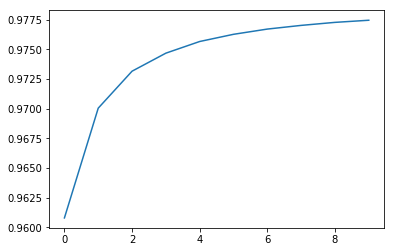

In [45]:
#let's see how the bagging works here
preds = np.stack([t.predict(df_test) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_test[0]
plt.plot([metrics.r2_score(y_test, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

# DL time!

In [55]:
train_ratio = 0.9
train_size = int(len(df) * train_ratio)
val_idx = list(range(train_size, len(df)))
train_size

355527

In [56]:
cat_vars = []

In [58]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y,
                                       cat_flds=cat_vars,bs=128,test_df=df_test)

In [59]:
emb_szs = []

In [60]:
md.get_learner??

In [61]:
m = md.get_learner(emb_szs, len(df.columns),
        0, 1, [1000,500], [0.001,0.01], y_range=[0,1], use_bn=True)
lr = 1e-3

In [62]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 62%|██████▏   | 1721/2778 [00:13<00:08, 130.24it/s, loss=0.0771]

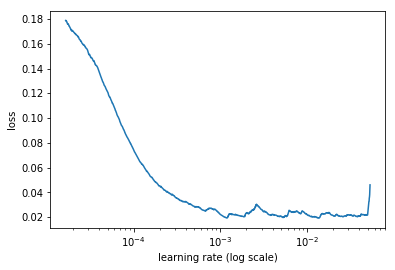

In [63]:
m.sched.plot(100)

### Sample

In [64]:
m = md.get_learner(emb_szs, len(df.columns),
                   0, 1, [48,48], [0.01,0.1], y_range=[0,1])
lr = 1e-4

In [65]:
m.fit(lr, 3, cycle_len=1,cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

 24%|██▍       | 667/2778 [00:06<00:19, 107.11it/s, loss=0.171]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                  
    0      0.106879   0.096159  
    1      0.038459   0.033663                                   
    2      0.03382    0.030048                                   
    3      0.024273   0.021368                                   
    4      0.022241   0.01872                                    
    5      0.021013   0.018075                                   
    6      0.020714   0.01799                                    



[0.017990347]

In [66]:
m.crit

<function torch._C._nn.mse_loss>

In [67]:
m.model

MixedInputModel(
  (embs): ModuleList(
  )
  (lins): ModuleList(
    (0): Linear(in_features=3, out_features=48)
    (1): Linear(in_features=48, out_features=48)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=48, out_features=1)
  (emb_drop): Dropout(p=0)
  (drops): ModuleList(
    (0): Dropout(p=0.01)
    (1): Dropout(p=0.1)
  )
  (bn): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True)
)

In [68]:
test_preds = m.predict(is_test=True)

In [69]:
m.save('astro-v1')

In [70]:
test_preds

array([[0.98258],
       [0.01147],
       [0.01016],
       [0.99737],
       [0.84604],
       [0.99331],
       [0.02259],
       [0.9905 ],
       [0.66433],
       [0.57968],
       [0.83977],
       [0.98458],
       [0.62201],
       [0.05543],
       [0.95248],
       [0.96647],
       [0.88864],
       [0.9516 ],
       [0.18233],
       [0.3981 ],
       ...,
       [0.99269],
       [0.23026],
       [0.2289 ],
       [0.02115],
       [0.91615],
       [0.02292],
       [0.99666],
       [0.84332],
       [0.9987 ],
       [0.08107],
       [0.2732 ],
       [0.34223],
       [0.99912],
       [0.85603],
       [0.00925],
       [0.97422],
       [0.22531],
       [0.99291],
       [0.03123],
       [0.99963]], dtype=float32)

In [71]:
len(test_preds),len(y_test)

(131677, 131677)

In [72]:
from sklearn.metrics import confusion_matrix
test_preds_bin = np.array([1 if x >= 0.93 else 0 for x in test_preds])
test_preds_bin

array([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, ..., 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1])

In [73]:
y_test_bin = np.array([1 if x >= 0.93 else 0 for x in y_test])

[[60896  1064]
 [ 9978 59739]]


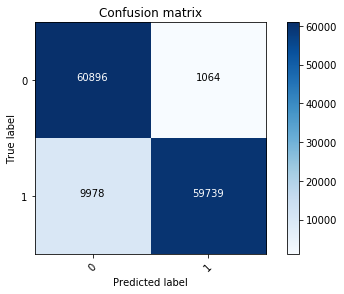

In [74]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_bin, test_preds_bin)
plot_confusion_matrix(cm,[0,1])